Install the packages required



In [ ]:
!pip install pydot --quiet
!pip install transformers --quiet
!pip install sentencepiece --quiet
!pip install nltk --quiet
!pip install torch --quiet

In [ ]:
# standard
import numpy as np
import pandas as pd


import sklearn as sk
from sklearn.feature_extraction.text import CountVectorizer
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt

import re
import string
import seaborn as sns
import os
import textwrap


import copy

from tqdm import tqdm
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    classification_report
)

import transformers
from transformers import (
    T5Tokenizer, 
    T5Model,
    T5ForConditionalGeneration,
    get_linear_schedule_with_warmup
)




In [ ]:
df_train = pd.read_csv("https://adamhyman-public.s3.amazonaws.com/w266/for_modeling/augmented_and_balanced/train_data_balanced.csv")

df_valid = pd.read_csv("https://adamhyman-public.s3.amazonaws.com/w266/for_modeling/augmented_and_balanced/validation_data_balanced.csv")

df_test = pd.read_csv("https://adamhyman-public.s3.amazonaws.com/w266/for_modeling/test_data.csv")

In [ ]:
df_train = df_train.astype({'toxic':'int', 'severe_toxic':'int', 'obscene':'int', 'threat':'int', 'insult':'int', 'identity_hate':'int'})
#There are 3 null comments in train dataset, 1 in valid and 1 in test. They need to be removed or we get error.
df_train = df_train.dropna(how='any',axis=0).reset_index(drop=True)
df_valid = df_valid.dropna(how='any',axis=0).reset_index(drop=True)
df_test = df_test.dropna(how='any',axis=0) .reset_index(drop=True)


df_train = df_train[df_train["comment_text"] != '']
df_valid = df_valid[df_valid["comment_text"] != '']
df_test = df_test[df_test["comment_text"] != '']

df_train = df_train.astype({'toxic':'int', 'severe_toxic':'int', 'obscene':'int', 'threat':'int', 'insult':'int', 'identity_hate':'int'})
df_valid = df_valid.astype({'toxic':'int', 'severe_toxic':'int', 'obscene':'int', 'threat':'int', 'insult':'int', 'identity_hate':'int'})
df_test = df_test.astype({'toxic':'int', 'severe_toxic':'int', 'obscene':'int', 'threat':'int', 'insult':'int', 'identity_hate':'int'})

In [ ]:
def  clean_text(text):
    text =  text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[-()\"\#/@;:{}`+=~|!?,]", "", text)
    text = text.translate(str.maketrans('', '', string.punctuation)) 
    text = re.sub("(\W)"," ",text) 

    return text
df_train["text"] = df_train['comment_text'].apply(lambda text: clean_text(text))
df_valid["text"] = df_valid['comment_text'].apply(lambda text: clean_text(text))
df_test["text"] = df_test['comment_text'].apply(lambda text: clean_text(text))


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,text
0,True,True,False,False,False,False,False,False,True
1,True,True,False,False,False,False,False,False,True
2,True,True,False,False,False,False,False,False,True
3,True,True,False,False,False,False,False,False,True
4,True,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...
3277,True,True,False,False,False,False,False,False,True
3278,True,True,False,False,False,False,False,False,True
3279,True,True,False,False,False,False,False,False,True
3280,True,True,False,False,False,False,False,False,True


In [ ]:
train_comments, train_labels = df_train["text"], df_train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
valid_comments, valid_labels = df_valid["text"], df_valid[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
test_comments, test_labels = df_test["text"], df_test[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

In [ ]:
def get_labels(df):
    labels_li = [' '.join(x.lower().split()) for x in df.columns.to_list()[:6]]
    labels_matrix = np.array([labels_li] * len(df))

    mask = df.iloc[:, :6].values.astype(bool)
    labels = []
    for l, m in zip(labels_matrix, mask):
        x = l[m]
        if len(x) > 0:
            labels.append(' , '.join(x.tolist()) + ' </s>')
        else:
            labels.append('none </s>')
    return labels

def get_texts(df):
    texts = 'multilabel classification: ' + df
    
    return texts


In [ ]:

texts = get_texts(train_comments)
labels = get_labels(train_labels)


for text, label in zip(texts[854:860], labels[854:860]):
     print(f'TEXT -\t{text}')
     print(f'LABEL -\t{label}')
     print()

val_texts = get_texts(valid_comments)
val_labels = get_labels(valid_labels)


for text, label in zip(val_texts[854:860], val_labels[854:860]):
     print(f'val TEXT -\t{text}')
     print(f'val LABEL -\t{label}')
     print()
# print(type(train_comments))


multilabel classification: lead paragraph the lead does not refers that the little girl and her siblings were left unattended in an unlocked ground floor hotel room while the parents went to a restaurant any reader will think that she disappeared while staying with her parents in the apartment and this was not what really happened
['none </s>', 'none </s>', 'none </s>', 'none </s>', 'none </s>']
       toxic  severe_toxic  obscene  threat  insult  identity_hate
0          0             0        0       0       0              0
1          0             0        0       0       0              0
2          0             0        0       0       0              0
3          0             0        0       0       0              0
4          0             0        0       0       0              0
...      ...           ...      ...     ...     ...            ...
13126      1             0        1       1       0              0
13127      1             0        0       1       1              

['severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


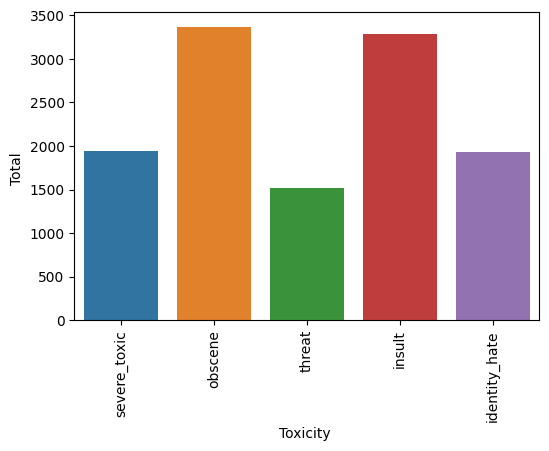

In [ ]:
categories = df_train.columns.to_list()[3:8]
plt.figure(figsize=(6, 4))
print(categories)

ax = sns.barplot(x=categories, y=df_train.iloc[:, 3:8].sum().values)
plt.ylabel('Total ')
plt.xlabel('Toxicity ')
plt.xticks(rotation=90)
plt.show()

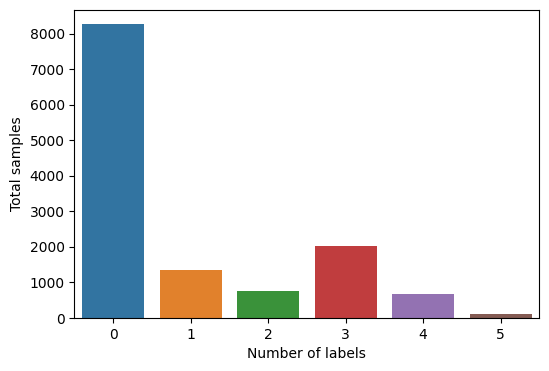

In [ ]:
# no of samples having multiple labels
row_sums = df_train.iloc[:, 3:8].sum(axis=1)
multilabel_counts = row_sums.value_counts()

plt.figure(figsize=(6, 4))
ax = sns.barplot(x=multilabel_counts.index, y=multilabel_counts.values)
plt.ylabel('Total samples')
plt.xlabel('Number of labels')
plt.show()

Feed the large T5 dataset

In [ ]:
class Config:
    def __init__(self):
        super(Config, self).__init__()

        self.SEED = 42
        self.MODEL_PATH = 't5-base'

        # data
        self.TOKENIZER = T5Tokenizer.from_pretrained(self.MODEL_PATH)
        self.SRC_MAX_LENGTH = 320
        self.TGT_MAX_LENGTH = 20
        self.BATCH_SIZE = 16
        self.VALIDATION_SPLIT = 0.25

        # model
        self.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.FULL_FINETUNING = True
        self.LR = 3e-5
        self.OPTIMIZER = 'AdamW'
        self.CRITERION = 'BCEWithLogitsLoss'
        self.SAVE_BEST_ONLY = True
        self.N_VALIDATE_DUR_TRAIN = 3
        self.EPOCHS = 2

config = Config()

/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [ ]:
class T5Dataset(Dataset):
    def __init__(self, df, texts, labels, indices, set_type=None):
        super(T5Dataset, self).__init__()

        df = df.iloc[indices]
        self.texts = get_texts(texts)
        self.set_type = set_type
        if self.set_type != 'test':
            self.labels = get_labels(labels)

        self.tokenizer = config.TOKENIZER
        self.src_max_length = config.SRC_MAX_LENGTH
        self.tgt_max_length = config.TGT_MAX_LENGTH

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, index):

        src_tokenized = self.tokenizer.encode_plus(
            self.texts[index], 
            max_length=self.src_max_length,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
        src_input_ids = src_tokenized['input_ids'].squeeze()
        src_attention_mask = src_tokenized['attention_mask'].squeeze()

        if self.set_type != 'test':
            tgt_tokenized = self.tokenizer.encode_plus(
                self.labels[index], 
                max_length=self.tgt_max_length,
                pad_to_max_length=True,
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=False,
                return_tensors='pt'
            )
            tgt_input_ids = tgt_tokenized['input_ids'].squeeze()
            tgt_attention_mask = tgt_tokenized['attention_mask'].squeeze()

            return {
                'src_input_ids': src_input_ids.long(),
                'src_attention_mask': src_attention_mask.long(),
                'tgt_input_ids': tgt_input_ids.long(),
                'tgt_attention_mask': tgt_attention_mask.long()
            }

        return {
            'src_input_ids': src_input_ids.long(),
            'src_attention_mask': src_attention_mask.long()
        }

In [ ]:

train_data = T5Dataset(df_train, train_comments, train_labels, len(train_comments)-1)

val_data = T5Dataset(df_valid, valid_comments, valid_labels, len(valid_comments)-1)



In [ ]:
train_dataloader = DataLoader(train_data, batch_size=config.BATCH_SIZE)
val_dataloader = DataLoader(val_data, batch_size=config.BATCH_SIZE)
print(val_dataloader)
b = next(iter(train_dataloader))
for k, v in b.items():
    print(f'{k} shape: {v.shape}')

src_input_ids shape: torch.Size([16, 320])
src_attention_mask shape: torch.Size([16, 320])
tgt_input_ids shape: torch.Size([16, 20])
tgt_attention_mask shape: torch.Size([16, 20])


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5.py:226: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


In [ ]:
class T5Model(nn.Module):
    def __init__(self):
        super(T5Model, self).__init__()

        self.t5_model = T5ForConditionalGeneration.from_pretrained(config.MODEL_PATH)

    def forward(
        self,
        input_ids, 
        attention_mask=None, 
        decoder_input_ids=None, 
        decoder_attention_mask=None, 
        labels=None
        ):

        return self.t5_model(
            input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            labels=labels,
        )


In [ ]:
print(config.DEVICE)
device = config.DEVICE

cuda


In [ ]:
def get_ohe(x):
    labels_li = ['_'.join(x.lower().split()) for x in df_train.columns.to_list()[3:8]]
    labels_li_indices = dict()
    for idx, label in enumerate(labels_li):
        labels_li_indices[label] = idx
        
    y = [labels.split(', ') for labels in x]
    ohe = []
    for labels in y:
        temp = [0] * 6
        for label in labels:
            idx = labels_li_indices.get(label, -1)
            if idx != -1:
                temp[idx] = 1
        ohe.append(temp)
    ohe = np.array(ohe)
    return ohe

In [ ]:
def val(model, val_dataloader, criterion):
    
    val_loss = 0
    true, pred = [], []
    
    # set model.eval() every time during evaluation
    model.eval()
    
    for step, batch in enumerate(val_dataloader):
        # unpack the batch contents and push them to the device (cuda or cpu).
        b_src_input_ids = batch['src_input_ids'].to(device)
        b_src_attention_mask = batch['src_attention_mask'].to(device)
    
        b_tgt_input_ids = batch['tgt_input_ids']
        labels = b_tgt_input_ids.to(device)
        labels[labels[:, :] == config.TOKENIZER.pad_token_id] = -100

        b_tgt_attention_mask = batch['tgt_attention_mask'].to(device)

        # using torch.no_grad() during validation/inference is faster -
        # - since it does not update gradients.
        with torch.no_grad():
            # forward pass
            outputs = model(
                input_ids=b_src_input_ids, 
                attention_mask=b_src_attention_mask,
                labels=labels,
                decoder_attention_mask=b_tgt_attention_mask)
            loss = outputs[0]

            val_loss += loss.item()

            # get true 
            for true_id in b_tgt_input_ids:
                true_decoded = config.TOKENIZER.decode(true_id)
                true.append(true_decoded)

            # get pred (decoder generated textual label ids)
            pred_ids = model.t5_model.generate(
                input_ids=b_src_input_ids, 
                attention_mask=b_src_attention_mask
            )
            pred_ids = pred_ids.cpu().numpy()
            for pred_id in pred_ids:
                pred_decoded = config.TOKENIZER.decode(pred_id)
                pred.append(pred_decoded)

    true_ohe = get_ohe(true)
    pred_ohe = get_ohe(pred)

    avg_val_loss = val_loss / len(val_dataloader)
    print('Val loss:', avg_val_loss)
    print('Val accuracy:', accuracy_score(true_ohe, pred_ohe))

    val_micro_f1_score = f1_score(true_ohe, pred_ohe, average='micro')
    print('Val micro f1 score:', val_micro_f1_score)
    return val_micro_f1_score


def train(
    model,  
    train_dataloader, 
    val_dataloader, 
    criterion, 
    optimizer, 
    scheduler, 
    epoch
    ):
    
    # we validate config.N_VALIDATE_DUR_TRAIN times during the training loop
    nv = config.N_VALIDATE_DUR_TRAIN
    temp = len(train_dataloader) // nv
    temp = temp - (temp % 100)
    validate_at_steps = [temp * x for x in range(1, nv + 1)]
    
    train_loss = 0
    for step, batch in enumerate(tqdm(train_dataloader, 
                                      desc='Epoch ' + str(epoch))):
        # set model.eval() every time during training
        model.train()
        
        # unpack the batch contents and push them to the device (cuda or cpu).
        b_src_input_ids = batch['src_input_ids'].to(device)
        b_src_attention_mask = batch['src_attention_mask'].to(device)
    
        labels = batch['tgt_input_ids'].to(device)
        labels[labels[:, :] == config.TOKENIZER.pad_token_id] = -100

        b_tgt_attention_mask = batch['tgt_attention_mask'].to(device)

        # clear accumulated gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(input_ids=b_src_input_ids, 
                        attention_mask=b_src_attention_mask,
                        labels=labels,
                        decoder_attention_mask=b_tgt_attention_mask)
        loss = outputs[0]
        train_loss += loss.item()

        # backward pass
        loss.backward()

        # update weights
        optimizer.step()
        
        # update scheduler
        scheduler.step()

        if step in validate_at_steps:
            print(f'-- Step: {step}')
            _ = val(model, val_dataloader, criterion)
    
    avg_train_loss = train_loss / len(train_dataloader)
    print('Training loss:', avg_train_loss)

In [ ]:
def run():
    # setting a seed ensures reproducible results.
    # seed may affect the performance too.
    torch.manual_seed(config.SEED)

    criterion = nn.BCEWithLogitsLoss()
    
    # define the parameters to be optmized -
    # - and add regularization
    if config.FULL_FINETUNING:
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {
                "params": [
                    p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.001,
            },
            {
                "params": [
                    p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.0,
            },
        ]
        optimizer = optim.AdamW(optimizer_parameters, lr=config.LR)

    num_training_steps = len(train_dataloader) * config.EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )

    max_val_micro_f1_score = float('-inf')
    for epoch in range(config.EPOCHS):
        train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, epoch)
        val_micro_f1_score = val(model, val_dataloader, criterion)

        if config.SAVE_BEST_ONLY:
            if val_micro_f1_score > max_val_micro_f1_score:
                best_model = copy.deepcopy(model)
                best_val_micro_f1_score = val_micro_f1_score

                model_name = 't5_best_model'
                torch.save(best_model.state_dict(), model_name + '.pt')

                print(f'--- Best Model. Val loss: {max_val_micro_f1_score} -> {val_micro_f1_score}')
                max_val_micro_f1_score = val_micro_f1_score

    return best_model, best_val_micro_f1_score

In [ ]:
model = T5Model()
model.to(device);

In [ ]:
best_model, best_val_micro_f1_score = run()


Epoch 0:  24%|██▍       | 200/821 [01:00<03:08,  3.29it/s]

-- Step: 200


/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Epoch 0:  24%|██▍       | 201/821 [02:38<5:04:48, 29.50s/it]

Val loss: 0.28420481064076564
Val accuracy: 0.6264472882388787
Val micro f1 score: 0.5150602409638555


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5.py:226: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
Epoch 0:  49%|████▊     | 400/821 [03:37<02:05,  3.36it/s]

-- Step: 400


/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Epoch 0:  49%|████▉     | 401/821 [05:17<3:30:59, 30.14s/it]

Val loss: 0.20378836665700362
Val accuracy: 0.7516758074344911
Val micro f1 score: 0.6271050521251003


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5.py:226: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
Epoch 0:  73%|███████▎  | 600/821 [06:17<01:06,  3.32it/s]

-- Step: 600


/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Epoch 0:  73%|███████▎  | 601/821 [07:58<1:51:44, 30.47s/it]

Val loss: 0.19151277597812774
Val accuracy: 0.7730042656916515
Val micro f1 score: 0.6635794061563607


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5.py:226: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
Epoch 0: 100%|██████████| 821/821 [09:04<00:00,  1.51it/s]
/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecate

Training loss: 0.5369848682659697
Val loss: 0.1765579403495615
Val accuracy: 0.7809262644728824
Val micro f1 score: 0.6927932667017359
--- Best Model. Val loss: -inf -> 0.6927932667017359


Epoch 1:   0%|          | 0/821 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5.py:226: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
Epoch 1:  24%|██▍       | 200/821 [00:59<03:05,  3.34it/s]

-- Step: 200


/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Epoch 1:  24%|██▍       | 201/821 [02:42<5:20:21, 31.00s/it]

Val loss: 0.17041441825336046
Val accuracy: 0.7882388787324802
Val micro f1 score: 0.694391244870041


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5.py:226: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
Epoch 1:  49%|████▊     | 400/821 [03:42<02:05,  3.36it/s]

-- Step: 400


/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Epoch 1:  49%|████▉     | 401/821 [05:26<3:40:32, 31.51s/it]

Val loss: 0.16163457254653127
Val accuracy: 0.7928092626447288
Val micro f1 score: 0.7162198035572074


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5.py:226: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
Epoch 1:  73%|███████▎  | 600/821 [06:26<01:06,  3.33it/s]

-- Step: 600


/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Epoch 1:  73%|███████▎  | 601/821 [08:09<1:54:23, 31.20s/it]

Val loss: 0.16069654641148534
Val accuracy: 0.7931139549055454
Val micro f1 score: 0.7120107962213226


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5.py:226: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
Epoch 1: 100%|██████████| 821/821 [09:15<00:00,  1.48it/s]
/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecate

Training loss: 0.19907915718789948
Val loss: 0.16052742875678447
Val accuracy: 0.7940280316879951
Val micro f1 score: 0.7168690958164643
--- Best Model. Val loss: 0.6927932667017359 -> 0.7168690958164643


In [ ]:
test_data = T5Dataset(df_test, test_comments, test_labels, len(test_comments)-1, set_type = 'test')

test_dataloader = DataLoader(test_data, batch_size=config.BATCH_SIZE)


In [ ]:
def predict(model):
    val_loss = 0
    pred = []
    model.eval()
    for step, batch in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        b_src_input_ids = batch['src_input_ids'].to(device)
        b_src_attention_mask = batch['src_attention_mask'].to(device)

        with torch.no_grad():
            # get pred
            pred_ids = model.t5_model.generate(
                input_ids=b_src_input_ids, 
                attention_mask=b_src_attention_mask
            )
            pred_ids = pred_ids.cpu().numpy()
            for pred_id in pred_ids:
                pred_decoded = config.TOKENIZER.decode(pred_id)
                pred.append(pred_decoded)

    pred_ohe = get_ohe(pred)
    return pred_ohe

pred_ohe = predict(best_model)

  0%|          | 0/3999 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 3999/3999 [23:48<00:00,  2.80it/s]


In [ ]:
print(best_val_micro_f1_score)
print(pred_ohe)
y_test = test_labels
y_test_pred = np.where(pred_ohe>=0.5, 1, 0)
y_test_pred[:10] 

0.7168690958164643
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [1 1 0 0 0 0]
 [0 0 0 0 0 0]]


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [ ]:
print(pred_ohe)
print(type(pred_ohe))

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [1 1 0 0 0 0]
 [0 0 0 0 0 0]]
<class 'numpy.ndarray'>


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred, target_names=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], zero_division = 0))

               precision    recall  f1-score   support

        toxic       0.53      0.60      0.56      6090
 severe_toxic       0.04      0.96      0.08       367
      obscene       0.52      0.06      0.10      3691
       threat       0.00      0.00      0.00       211
       insult       0.00      0.00      0.00      3427
identity_hate       0.00      0.00      0.00       712

    micro avg       0.26      0.29      0.28     14498
    macro avg       0.18      0.27      0.12     14498
 weighted avg       0.36      0.29      0.26     14498
  samples avg       0.03      0.03      0.03     14498



In [ ]:
from sklearn.metrics import hamming_loss
hamming_loss(y_test, y_test_pred)

0.05739490193626378

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_test_pred, average=None)

array([0.77105279, 0.92196338, 0.52632976, 0.49753129, 0.5       ,
       0.5       ])

In [ ]:
roc_auc_score(y_test, y_test_pred, average="macro")

0.6194795379675934